# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFViTModel
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax, Adam,AdamW
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D



import warnings
warnings.filterwarnings('ignore')

# Data

### Train

In [27]:
train_dir = '/kaggle/input/nn-project/train/train/train'

classes = os.listdir(train_dir)
classes

['tomato_fully_ripened',
 'tomato_half_ripened',
 'banana_overripe',
 'banana_rotten',
 'banana_unripe',
 'banana_ripe',
 'tomato_green']

In [28]:
image_paths = []
image_labels = []

categories = os.listdir(train_dir)

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

train_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
train_df

,filepaths,labels
0,/kaggle/input/nn-project/train/train/train/tom...,tomato_fully_ripened
1,/kaggle/input/nn-project/train/train/train/tom...,tomato_fully_ripened
2,/kaggle/input/nn-project/train/train/train/tom...,tomato_fully_ripened
3,/kaggle/input/nn-project/train/train/train/tom...,tomato_fully_ripened
4,/kaggle/input/nn-project/train/train/train/tom...,tomato_fully_ripened
...,...,...
7390,/kaggle/input/nn-project/train/train/train/tom...,tomato_green
7391,/kaggle/input/nn-project/train/train/train/tom...,tomato_green
7392,/kaggle/input/nn-project/train/train/train/tom...,tomato_green
7393,/kaggle/input/nn-project/train/train/train/tom...,tomato_green


### Test

In [29]:
test_dir = '/kaggle/input/nn-project/testNew/testNew'
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

In [30]:
test_df = pd.DataFrame({'filepaths': test_image_paths})
test_df

,filepaths
0,/kaggle/input/nn-project/testNew/testNew/testi...
1,/kaggle/input/nn-project/testNew/testNew/testi...
2,/kaggle/input/nn-project/testNew/testNew/testi...
3,/kaggle/input/nn-project/testNew/testNew/testi...
4,/kaggle/input/nn-project/testNew/testNew/testi...
...,...
2479,/kaggle/input/nn-project/testNew/testNew/testi...
2480,/kaggle/input/nn-project/testNew/testNew/testi...
2481,/kaggle/input/nn-project/testNew/testNew/testi...
2482,/kaggle/input/nn-project/testNew/testNew/testi...


### Splitting and Data Augmentation

In [31]:
train, valid_df = train_test_split(train_df, test_size=0.2, random_state=101)

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_int = le.fit_transform(train_df['labels'])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
index_weights = dict(enumerate(class_weights))

index_weights

{0: 0.6815668202764977,
 1: 0.6602678571428572,
 2: 0.4786717586898828,
 3: 0.6941055002815844,
 4: 19.207792207792206,
 5: 2.8475163650365807,
 6: 11.738095238095237}

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.7, 1.3),
    channel_shift_range=30.0,
    rescale=1./255,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
gen_train = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32
)

Found 5916 validated image filenames belonging to 7 classes.


In [35]:
gen_valid=test_val_datagen.flow_from_dataframe(valid_df,x_col='filepaths',y_col='labels',target_size=(224,224),class_mode='categorical',shuffle=False,color_mode='rgb',batch_size=32)
gen_test = test_val_datagen.flow_from_dataframe(test_df,x_col='filepaths',y_col=None,target_size=(224, 224),class_mode=None,shuffle=False,color_mode='rgb',batch_size=32)

Found 1479 validated image filenames belonging to 7 classes.
Found 2484 validated image filenames.


# Transformer Model

### Patch and Positional Embeddings

In [ ]:
def create_patch_and_position_embedding(image_size=(224, 224, 3), patch_size=16, projection_dim=768):
    num_patches = (224 // patch_size) ** 2 #(224 // 16) ** 2=196

    inputs = keras.Input(shape=image_size)

    #embeddings
    patches = Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding_projection"
    )(inputs)  #each patch(768 pixels) passed into conv2d that has 768 filters, each one produce 1 number, get the outputemb (768)


    patches = layers.Reshape((num_patches, projection_dim))(patches)
   
   
    positions = tf.range(start=0, limit=num_patches) #number of pos embedders, each one associated with one embedding
    position_embedding = layers.Embedding(
        input_dim=num_patches, #no of pos embd
        output_dim=projection_dim, #size of each pos emb 
        name="position_embedding"
    )(positions) #returns (num_patches, projection_dim)

    final_embeddings = patches + position_embedding
    return inputs, final_embeddings

### Transformer Encoder

In [ ]:
def transformer_encoder(embeddings, num_heads=12, projection_dim=768, mlp_dim=3072, num_layers=12):
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)  #normalize input(embedding), epsilon number used in equation
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads, #dim QKV
            dropout=0.1 #10% of att scores(after softmax)=0 
        )(query=x1, value=x1,key=x1) #compute Q=x1*wq, K=x1*wk....

        x2 = layers.Add()([attention_output, embeddings])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) #then normalize again

        x3 = keras.Sequential([ #input is 768
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dense(projection_dim), #out=768
        ])(x3) #ffd

        embeddings = layers.Add()([x3, x2]) #add again
    return embeddings

### Classification Head

In [ ]:
def classification_head(embeddings, num_classes=1000):
    #before classifation, nomralize the add 
    x = layers.LayerNormalization(epsilon=1e-6)(embeddings)
    x = layers.GlobalAveragePooling1D()(x) #sim to flatten
    return layers.Dense(num_classes, activation="softmax")(x)

### Build the Model

In [ ]:
def create_vit_base_model(image_size=(224, 224, 3), patch_size=16, projection_dim=768, num_heads=12,
                          transformer_layers=12, mlp_head_units=[3072], num_classes=1000):
    inputs, embeddings = create_patch_and_position_embedding(image_size, patch_size, projection_dim)
    transformer_output = transformer_encoder(embeddings,num_heads=num_heads,projection_dim=projection_dim,mlp_dim=mlp_head_units[0], #first elemtn in the list(3072)num_layers=transformer_layers
    )
    outputs = classification_head(transformer_output, num_classes)
    return keras.Model(inputs, outputs)

In [40]:
vit_model = create_vit_base_model(num_classes=7)
vit_model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_projection      │ (None, 14, 14, 768)    │        590,592 │ input_layer_26[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 196, 768)       │              0 │ embedding_projection[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_50 (Add)              │ (None, 196, 768)       │              0 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_50    │ (None, 196, 768)       │          1,536 │ add_50[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 196, 768)       │      2,362,368 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_51 (Add)              │ (None, 196, 768)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_50[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_51    │ (None, 196, 768)       │          1,536 │ add_51[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_24             │ (None, 196, 768)       │      4,722,432 │ layer_normalization_5… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_52 (Add)              │ (None, 196, 768)       │              0 │ sequential_24[0][0],   │
│                           │                        │                │ add_51[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_52    │ (None, 196, 768)       │          1,536 │ add_52[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_25   │ (None, 196, 768)       │      2,362,368 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_53 (Add)              │ (None, 196, 768)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_52[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_53    │ (None, 196, 768)       │          1,536 │ add_53[0][0]           │
│ (LayerNormalization) 

 Total params: 85,651,975 (326.74 MB)

 Trainable params: 85,651,975 (326.74 MB)

 Non-trainable params: 0 (0.00 B)

### Load pre-trained weights into custom vit model

In [ ]:
hf_model = TFViTModel.from_pretrained("google/vit-base-patch16-224")

hf_weights = {weight.name: weight.numpy() for weight in hf_model.weights}

for layer in vit_model.layers:
    if layer.name in hf_weights:
        if "kernel" in hf_weights[layer.name]:
            weight = hf_weights[layer.name].T
        else:
            weight = hf_weights[layer.name]
        layer.set_weights([weight])

print("Weights loaded successfully!")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Weights loaded successfully!


# Model Finetuning

In [ ]:
optimizer =AdamW(
    weight_decay=1e-2, #reg strength
    learning_rate=5e-5
) #adamw has reg

vit_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [43]:
early_stopping=EarlyStopping(monitor='val_loss',mode='min',patience=15,restore_best_weights=True)

In [47]:
history= vit_model.fit(gen_train,validation_data=gen_valid,epochs=50,callbacks=[early_stopping],class_weight=index_weights)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8298 - loss: 0.7390 - val_accuracy: 0.8709 - val_loss: 0.3297
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8127 - loss: 0.6688 - val_accuracy: 0.8377 - val_loss: 0.4274
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8303 - loss: 0.7194 - val_accuracy: 0.8330 - val_loss: 0.4058
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8381 - loss: 0.5870 - val_accuracy: 0.8641 - val_loss: 0.3241
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8420 - loss: 0.6595 - val_accuracy: 0.8546 - val_loss: 0.3389
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8438 - loss: 0.6285 - val_accuracy: 0.8411 - val_loss: 0.4164
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8470 - loss: 0.6077 - val_accuracy: 0.8688 - val_loss: 0.3254
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8581 - loss: 0.5741 - val_accu

In [48]:
losses=pd.DataFrame(history.history)

Text(0.5, 1.0, 'Model Accuracy')

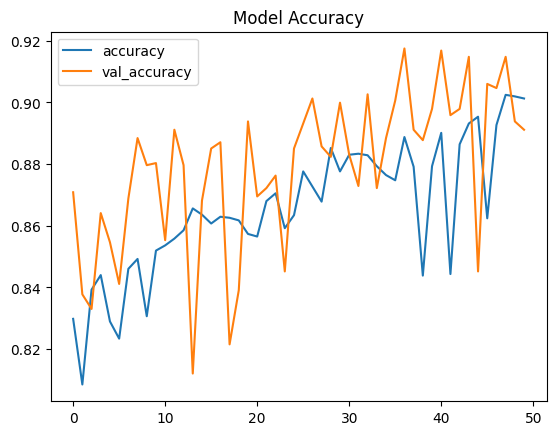

In [49]:
losses[['accuracy','val_accuracy']].plot()
plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Loss')

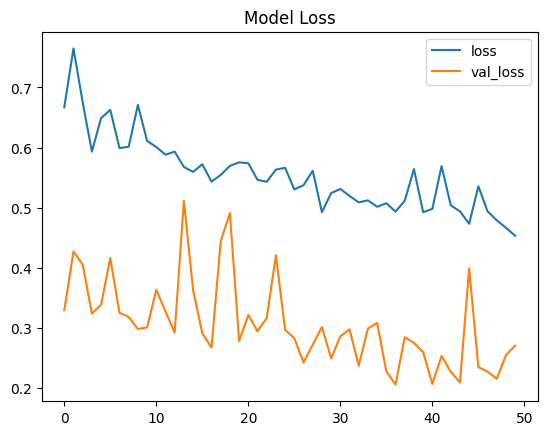

In [50]:
losses[['loss','val_loss']].plot()
plt.title('Model Loss')

In [51]:
val_loss, val_accuracy=vit_model.evaluate(gen_valid)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.9195 - loss: 0.2093
Validation Loss: 0.2064
Validation Accuracy: 0.9175


In [52]:
pred=vit_model.predict(gen_valid)
predictions=np.argmax(pred,axis=1)
print(classification_report(gen_valid.classes,predictions))

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 432ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       325
           1       0.93      0.95      0.94       301
           2       0.94      0.93      0.93       455
           3       0.97      0.98      0.98       308
           4       0.18      1.00      0.30         5
           5       0.91      0.47      0.62        66
           6       0.31      0.42      0.36        19

    accuracy                           0.92      1479
   macro avg       0.74      0.81      0.72      1479
weighted avg       0.93      0.92      0.92      1479



In [53]:
vit_model.save('transformer_model.keras')

In [58]:
model=load_model('transformer_model.keras')

In [60]:
predictions = model.predict(gen_test)
predictions=np.argmax(predictions,axis=1)

image_ids = [os.path.basename(path) for path in test_df['filepaths']]
submission = pd.DataFrame({'ImageID': image_ids, 'Class': predictions})

78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 583ms/step


In [61]:
submission

,ImageID,Class
0,testimage_1318.jpg,2
1,testimage_2053.jpg,3
2,testimage_1958.jpg,2
3,testimage_934.jpg,2
4,testimage_1677.jpg,2
...,...,...
2479,testimage_2143.jpg,1
2480,testimage_1123.jpg,1
2481,testimage_52.jpg,3
2482,testimage_132.jpg,3


In [62]:
submission.to_csv('transformer_submisson.csv',index=False)